# Impact of the k parameter - AIDS using R



On this notebook, we present the R code to display the figure XXXXXX of the article [lien_papier].


We focus our analysis on the impact of the parameter k in the statistical conservation and the security level of the dataset.

We performed 3 analyses:
    
    1- An FAMD (Factor Analysis for Mixed Data) projection of two Avatar dataset (high k versus low k) on the two first components of FAMD built on the Original dataset to observe the structural similarities
    
    2 - Evolution of the hazard ratio accorss k
    
    3 - Protection level computation (local cloaking) for different k values.


## Libraries importation

In [1]:
# Main libraries
library(reticulate)
library(tidyr)
library(tidyverse)
library(mice)
library(dplyr)
library(reshape2)


# Multidimensionnal reduction method libary
library(FactoMineR)

# Survival analysis libraries
library(survival)
library(survminer)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ dplyr   1.0.7
✔ tibble  3.1.6     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: ggpubr



In [13]:
colors = read.csv("../../color.csv", stringsAsFactors = FALSE)
rownames(colors) = colors$type


In [3]:
# import specific function to compute metrics 
py_run_string("import sys")
py_run_string("sys.path.append('../../lsg')")

py_run_string("from lsg.security_metrics.security_metrics_class import Security_metrics ")
py_run_string("from lsg.dimension.projection import Projection")
py_run_string("from lsg.security_metrics.record_to_avatar_distance import record_to_avatar_distance")
py_run_string("from lsg.security_metrics.local_cloaking import local_cloaking")
py_run_string("from lsg.security_metrics.avatars_are_first_hit import avatars_are_first_hit")
py_run_string("from lsg.security_metrics.hidden_rate import hidden_rate")



ERROR: Error in py_run_string_impl(code, local, convert): ModuleNotFoundError: No module named 'lsg'

Detailed traceback:
  File "<string>", line 1, in <module>
  File "/home/julien/R/x86_64-pc-linux-gnu-library/4.0/reticulate/python/rpytools/loader.py", line 39, in _import_hook
    module = _import(



In [ ]:
save <- FALSE

seq_k = c(4, 200, 400, 600, 800, 1000)


## Data loading

In [4]:
file_data <- "../../datasets/"
file_results <- "../../figure/"

In [5]:
data <- read.csv(paste0(file_data, "AIDS/aids_original_data.csv"), sep = ";", na.strings = c("NA", "", NA))
data <- data[,-1]

### Data imputation

In [6]:
data_imp <- complete(mice(data,m=1,maxit=50,seed=500, printFlag = FALSE),1)
data$cd496 <- data_imp$cd496

data_num = data[,]
categorical = c('hemo','homo', 'drugs', 'karnof', 'oprior', 'z30', 'zprior', 'race', 
            'gender', 'str2', 'strat', 'symptom', 'treat', 'offtrt', 'r','cens',
            'arms')
data[categorical] = lapply(data[categorical], factor)


Warning message:
“Number of logged events: 51”


## Functions

In [7]:
write_pvalue <- function(val, dec) {
  if(is.na(val)){
    return(NA)
  }else if (val < 0.001) {
    return("<0.001")
  } else {
    return(formatC(val, format = 'f', digits = dec))
  }
}

## Projection comparison small k versus high k 

We perform 2 FAMD, small k value (i.e. 1/10% of the total number of individuals) and high k value (i.e. 40/50% of the total number of individuals).

In [8]:
# Small k
k = 4 ; iter = 0

avatar_tot <- read.table(unz(paste0(file_data, "AIDS/aids_avatarized.zip"), 
                             paste0("aids_avatarized/k", k, "_aids_avatarized.csv")), sep = ",", header = TRUE)
avatar_small <- avatar_tot[avatar_tot$iter_k == iter,]

# Imputation
avatar_small_imp <- complete(mice(avatar_small,m=1,maxit=50,seed=500, printFlag = FALSE),1)
avatar_small$cd496 <- avatar_small_imp$cd496
avatar_small[categorical] = lapply(avatar_small[categorical], factor)

Warning message:
“Number of logged events: 3”


In [9]:
# High k = N/2
k = 1166 
iter = 1
avatar_tot <- read.table(unz(paste0(file_data, "AIDS/aids_avatarized.zip"), 
                             paste0("aids_avatarized/k", k, "_aids_avatarized.csv")), sep = ",", header = TRUE)
avatar_med <- avatar_tot[avatar_tot$iter_k == iter,]

# Imputation
avatar_med_imp <- complete(mice(avatar_med,m=1,maxit=50,seed=500, printFlag = FALSE),1)
avatar_med$cd496 <- avatar_med_imp$cd496
avatar_med[categorical] = lapply(avatar_med[categorical], factor)

Warning message:
“Number of logged events: 3”


In [10]:
# binding data, avatar small and avatar high
data_small_med <- rbind(data[,1:26], avatar_small[,1:26], avatar_med[,1:26])

row.names(data_small_med) <- 1:nrow(data_small_med)

# perform projection
pca <- FAMD(data_small_med, ncp = 5, graph = FALSE, ind.sup = (nrow(data_small_med)/3 +1):nrow(data_small_med))



In [11]:
res_ind_2D = as.data.frame(pca$ind.sup$coord)[1:2139, c('Dim.1', 'Dim.2')]
res_ind_sup = as.data.frame(pca$ind.sup$coord)[2140:4278,]
res_ind_2D['type'] = 'k= 4'
res_ind_sup['type'] = 'k= 1166'
res_ind_2D = rbind(res_ind_2D, res_ind_sup[, c('Dim.1', 'Dim.2', 'type')])

set.seed(42)
rows <- sample(nrow(res_ind_2D))
res_ind_2D <- res_ind_2D[rows, ]



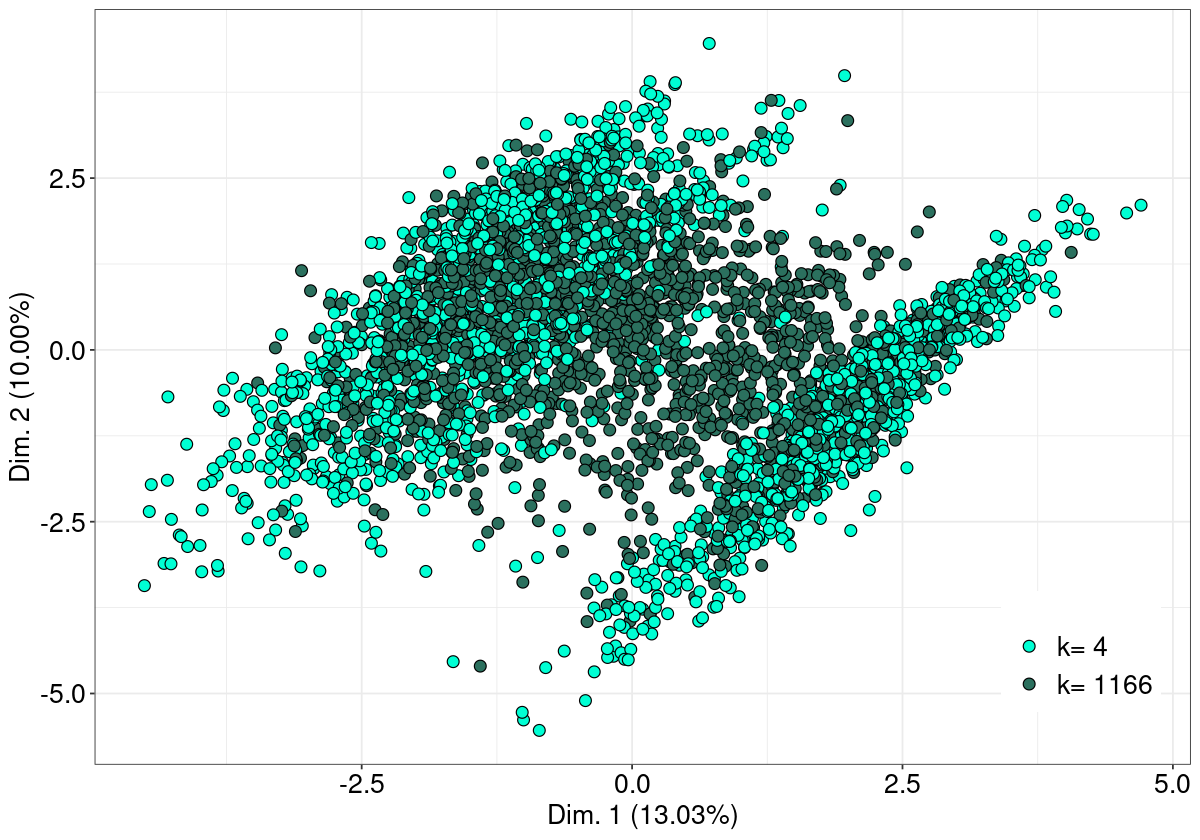

In [14]:
options(repr.plot.width = 10, repr.plot.height = 7)


plot = ggplot(res_ind_2D, aes(x=Dim.1, y=Dim.2, fill=type)) +
    # point
    geom_point(size=3, shape=21, alpha= 1) +
    # fill by k value
    aes(fill = factor(type)) + 
    scale_fill_manual(values=c( 'k= 4' = colors["k_small","color"], 'k= 1166' = colors["k_high","color"])) +
    # theme and details
    xlab(paste0("Dim. 1 (", formatC(pca$eig[1,2], format = "f", digits = 2) ,"%)")) +
    ylab(paste0("Dim. 2 (", formatC(pca$eig[2,2], format = "f", digits = 2) ,"%)")) +
    labs(fill = "") +
    theme_bw()+
    theme(legend.position = c(0.9,0.15),
         legend.text = element_text(size = 16, color = "black", family="sans"),
         legend.key.size = unit(0.8, "cm"),
         axis.text = element_text(size =  16, color="black", family="sans"),
         axis.title = element_text(size = 16, color = "black", family="sans"),
         legend.background = element_rect(fill = "white", linetype = "solid"))

plot

ggsave(file="../../figure/aids_pca2D_k_small_high.svg", plot=plot, width=10, height=7, dpi = 320)



## Relative hazard ratio accross  k 

We compute relative hazard ratio according the parameter k.


### Relative hazard ratio with Original data 

To compare, we first compute relative hasard ratio for original data

In [24]:
data[] <- lapply(data, function(x) {
    if(is.factor(x)) as.numeric(as.character(x)) else x
})

n_arms <- as.vector(table(data$arms))
cens_arms <- paste0(as.vector(table(data$cens, data$arms)[2,]), " (", 
                    as.vector(round(prop.table(table(data$cens, data$arms), 2)[2, ]*100, 1)), ")")

summary_cox <- summary(coxph(Surv(time = days/7, event = cens)~factor(arms), data = data))

In [25]:
HR_arms <- c("ref", round(as.vector(summary_cox$coefficients[,2]), 2))
CI_low_arms <- c(NA, round(as.vector(summary_cox$conf.int[,3]), 2))
CI_high_arms <- c(NA, round(as.vector(summary_cox$conf.int[,4]), 2))
p_arms <- c(NA, sapply(as.vector(summary_cox$coefficients[,5]), write_pvalue, dec = 3))

In [26]:
table2_data <- t(data.frame("n" = n_arms, "cens_1" = cens_arms, "HR" = HR_arms, 
                            "CI_HR_95" = c(NA, paste0(CI_low_arms[-1], "-", CI_high_arms[-1])), 
                            "p" = p_arms, row.names = c("0", "1", "2", "3")))
table2_data

,0,1,2,3
n,532,522,524,561
cens_1,181 (34),103 (19.7),109 (20.8),128 (22.8)
HR,ref,0.49,0.52,0.59
CI_HR_95,NA,0.39-0.63,0.41-0.67,0.47-0.73
p,NA,<0.001,<0.001,<0.001


### Parallele computing : not requiered if you import results datasets (below)
The following cells computes relatives hazard ratio according different k values.  
The computation is very time consuming (multiple hours), we save results in a dataframe.


In [27]:
pr <- py$Projection()
coord_original <- pr$fit_transform(data, nf = 5L)[[1]]

In [28]:
compute = FALSE

if (compute){
    

    ## parallele computing (not requiered if you import results datasets)
    library(doParallel)
    library(parallel)
    library(foreach)
    
    parralele_function = function(k){
    
    avatar_tot <- read.table(unz(paste0("../../datasets/aids_avatarized.zip"), 
                                     paste0("aids_avatarized/k", k, "_aids_avatarized.csv")), sep = ",", header = TRUE)
    
    for (iter in 0:9) {
       
        avatar <- avatar_tot[avatar_tot$iter_k == iter,1:26]
        
        ## imputation
        avatar_imp <- tidyr::complete(mice::mice(avatar,m=1,maxit=50,seed=500, printFlag = FALSE, print = FALSE),1)
        avatar$cd496 <- avatar_imp$cd496
        
        ## survival analysis
        summary_cox <- summary(survival::coxph(survival::Surv(time = days/7, event = cens)~factor(arms), data = avatar))
        res_HR <- c(round(as.vector(summary_cox$coefficients[,2]), 2))
        res_HR_CI_low <- c(round(as.vector(summary_cox$conf.int[,3]), 2))
        res_HR_CI_high <- c(round(as.vector(summary_cox$conf.int[,4]), 2))
        res_pval <- sapply(as.vector(summary_cox$coefficients[,5]), write_pvalue, dec = 3)
    
        res_row = c(k,iter,res_HR, res_HR_CI_low, res_HR_CI_high,res_pval )
        res_df[nrow(res_df) + 1,] = res_row  
        }
    return (res_df)
    }


    # Initialization
    res_df = data.frame(matrix(ncol = 14, nrow = 0))


    x = c("k", "iter", "res_HR1", "res_HR2", "res_HR3", 
        "res_HR_CI_low1", "res_HR_CI_low2", "res_HR_CI_low3",
       "res_HR_CI_high1", "res_HR_CI_high2", "res_HR_CI_high3",
       "res_pval1", "res_pval2", "res_pval3")

    colnames(res_df) <- x
        
    ## data loading
    p = seq(1,1999, 2)


    P <- 8  # define number of core 
    cl <- makeCluster(P) # start parallele computing

    clusterExport(cl, c("write_pvalue", "res_df"))

    system.time(
     res_par <- clusterApply(cl, p, fun = parralele_function) # eval parralele_function accross k  

    )  


    stopCluster(cl)
    
    ### Save results
    class(res_par)
    res_df = bind_rows(res_par)
    tail(res_df)
} 



### Load results datasets

In [29]:
res_df = read.csv("../../datasets/results_df/hazard_ratio.csv")

res_df["names"] = paste(res_df$k, res_df$iter, sep = "_")

df_res_HR = res_df[,c("k", "iter", "res_HR1", "res_HR2", "res_HR3")]
df_res_HR_CI_low = res_df[,c("k", "iter", "res_HR_CI_low1", "res_HR_CI_low2", "res_HR_CI_low3" )]
df_res_HR_CI_high = res_df[,c("k", "iter", "res_HR_CI_high1", "res_HR_CI_high2", "res_HR_CI_high3")]



In [30]:
# compute confidence intervals
mean_hr1 = res_df %>%
  group_by(k) %>%
  summarise(mean = mean(res_HR1),
            std = sqrt(var(res_HR1)),
            lower = mean(res_HR1) - qnorm(.975)*std/sqrt(n()),
            upper = mean(res_HR1) + qnorm(.975)*std/sqrt(n()))
mean_hr1$inf = mean_hr1$mean - mean_hr1$std
mean_hr1$sup = mean_hr1$mean + mean_hr1$std

poly_df <- rbind(setNames(mean_hr1[,c("k", "inf")],c('x','y')),
                 setNames(mean_hr1[order(nrow(mean_hr1):1),c("k", "sup")], c('x','y'))
                )


### Graphical representations

Warning message:
“Removed 156 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 156 rows containing non-finite values (stat_smooth).”

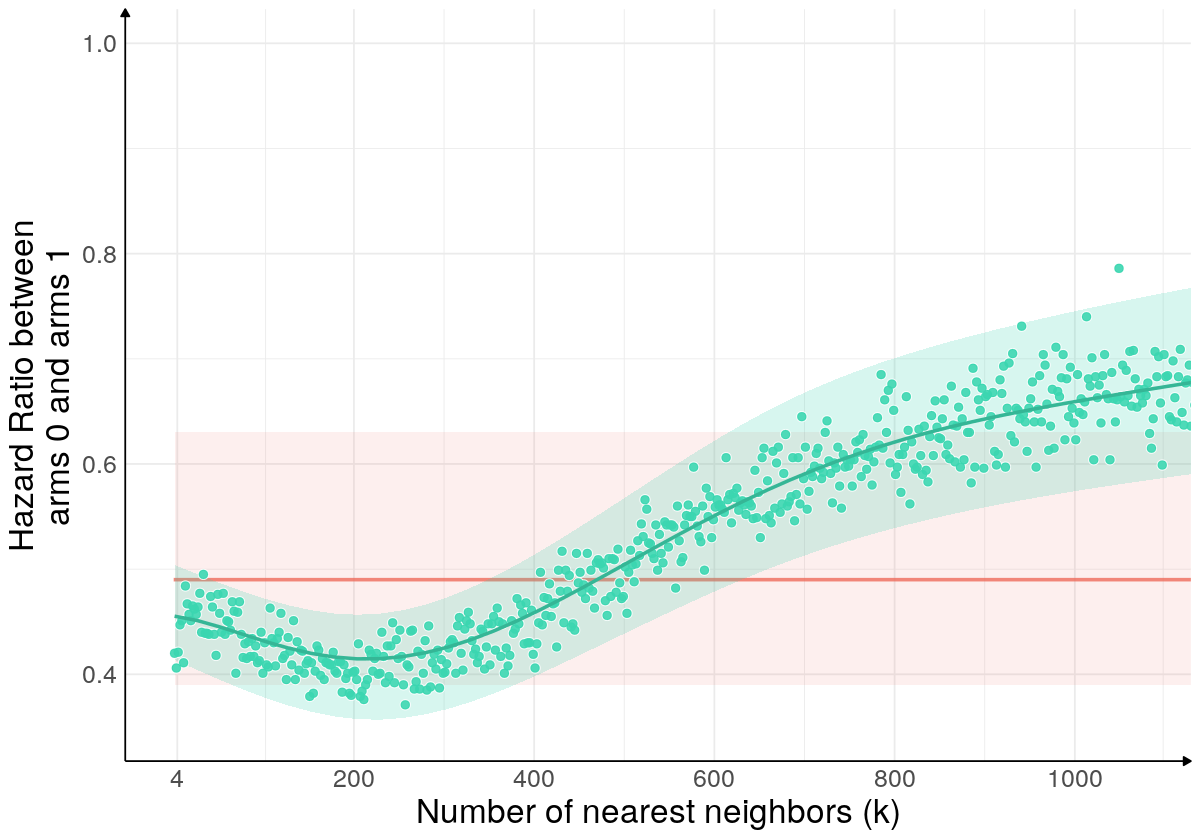

In [96]:

g1 = ggplot(res_df) +
        # red line as a ploygone
        stat_smooth(aes(k, res_HR1), method="lm", se=FALSE, 
                    formula= y ~ poly(x, 8, raw=TRUE), colour="red") +
        # add upper and lower bounds
        stat_smooth(data = mean_hr1, aes(k, mean - std), col = "#696969", lty = 2, se = FALSE, 
                    method = 'gam', formula = y ~ s(x, bs = "cs")) +
        stat_smooth(data = mean_hr1, aes(k, mean + std), col = "#696969", lty = 2, se = FALSE,
                    method = 'gam', formula = y ~ s(x, bs = "cs")) 


gg1 <- ggplot_build(g1)
# get stat smooth (2,3) coordinate in order to draw the polygone between the smooth curve
df2 <- data.frame(x = gg1$data[[2]]$x,
                  ymin = gg1$data[[2]]$y,
                  ymax = gg1$data[[3]]$y) 

df3 <- data.frame(x = gg1$data[[2]]$x,
                  ymin = 0.39,
                  ymax = 0.63) 


# draw final figure 
# we must redo all the code lines to manage the layer order (point on the grey zone)

plot = ggplot() +
         # original zone 
        geom_ribbon(data = df3, aes(x = x, ymin = ymin, ymax = ymax),
              fill = "#ED6A5A", alpha = 0.1) + 
        # add original mean
        geom_segment(aes(x = 0, y = 0.49, xend = 1175, yend = 0.49), 
                     col = "#ED6A5A", 
                     lwd = 1, 
                     lty = 1, 
                     alpha = 0.8) +
       
        # avatar zone 
        geom_ribbon(data = df2, aes(x = x, ymin = ymin, ymax = ymax),
              fill = colors["avatar", "color"], alpha = 0.2) + 
        theme_minimal() +
    
        # add mean point by k
        geom_point(data = mean_hr1, aes(x = k, y = mean), 
                   colour = "white", 
                   alpha =0.9,
                  size = 2.5) +
        geom_point(data = mean_hr1, aes(x = k, y = mean), 
                   colour = colors["avatar", "color"], 
                   alpha =0.9,
                  size = 2) +
        # avatar mean smooth
        stat_smooth(data = res_df, aes(k, res_HR1), method="lm", se=FALSE, 
                    formula= y ~ poly(x, 8, raw=TRUE), colour="#35b696") +
        
        # labs theme and axis
        ylab("Hazard Ratio between\narms 0 and arms 1") +
        xlab("Number of nearest neighbors (k)") +
        ylim(0.35, 1)+
        scale_x_continuous(breaks = seq_k)  +
        coord_cartesian(xlim = c(0, 1075)) +
        theme(axis.title.y = element_text(angle = 90, vjust = 1, size = 20, family="sans"),
              axis.text=element_text(size=15), 
              axis.title.x = element_text(size = 20, family="sans"),
              legend.text = element_text(size = 15, family="sans"),
              legend.key.size = unit(1, 'cm'),
              axis.line = element_line(colour = "black", 
              size = 0.5, linetype = "solid", arrow = arrow(type='closed', length = unit(5,'pt'))))
plot

ggsave(file="../../figure/aids_hazardratio_variousk.svg", plot=plot, width=10, height=6)


## For different k : local cloaking computation

This section provides the computation of protection metrics (local cloaking).

We first compute metrics, which need the security metrics specifique function.
Then we display the distribution of the local cloaking for different k values.

In [59]:
df_local_cloaking_k100 <- data.frame(row.names = 1:nrow(data))
pr = py$Projection()
hidden_rate_list = c()


coord_original = pr$fit_transform(data, nf = 5L)[[1]]
for (k in seq_k) {
    iter = 0
    avatar_tot <- read.table(unz(paste0(file_data, "AIDS/aids_avatarized.zip"), 
                                 paste0("aids_avatarized/k", k, "_aids_avatarized.csv")), sep = ",", header = TRUE)
    avatar <- avatar_tot[avatar_tot$iter_k == iter,]
    avatar_imp <- complete(mice(avatar,m=1,maxit=50,seed=500, printFlag = FALSE),1)
    avatar$cd496 <- avatar_imp$cd496
    coord_avatar = pr$transform(avatar[,1:(ncol(avatar) - 3)])
    
    # local cloaking
    distances = py$record_to_avatar_distance(coord_original, coord_avatar)
    local_cloaking <- py$local_cloaking(coord_original, coord_avatar, distances)
    df_local_cloaking_k100[paste0("local_cloaking_", k)] <- local_cloaking$hit_counts[,1]
    
}

Warning message:
“Number of logged events: 3”Warning message:
“Number of logged events: 3”Warning message:
“Number of logged events: 3”Warning message:
“Number of logged events: 3”Warning message:
“Number of logged events: 3”Warning message:
“Number of logged events: 3”

In [60]:
df_melt <- melt(df_local_cloaking_k100)

No id variables; using all as measure variables


### Violin plot 
We perform a violin plot for different k value with a log axis

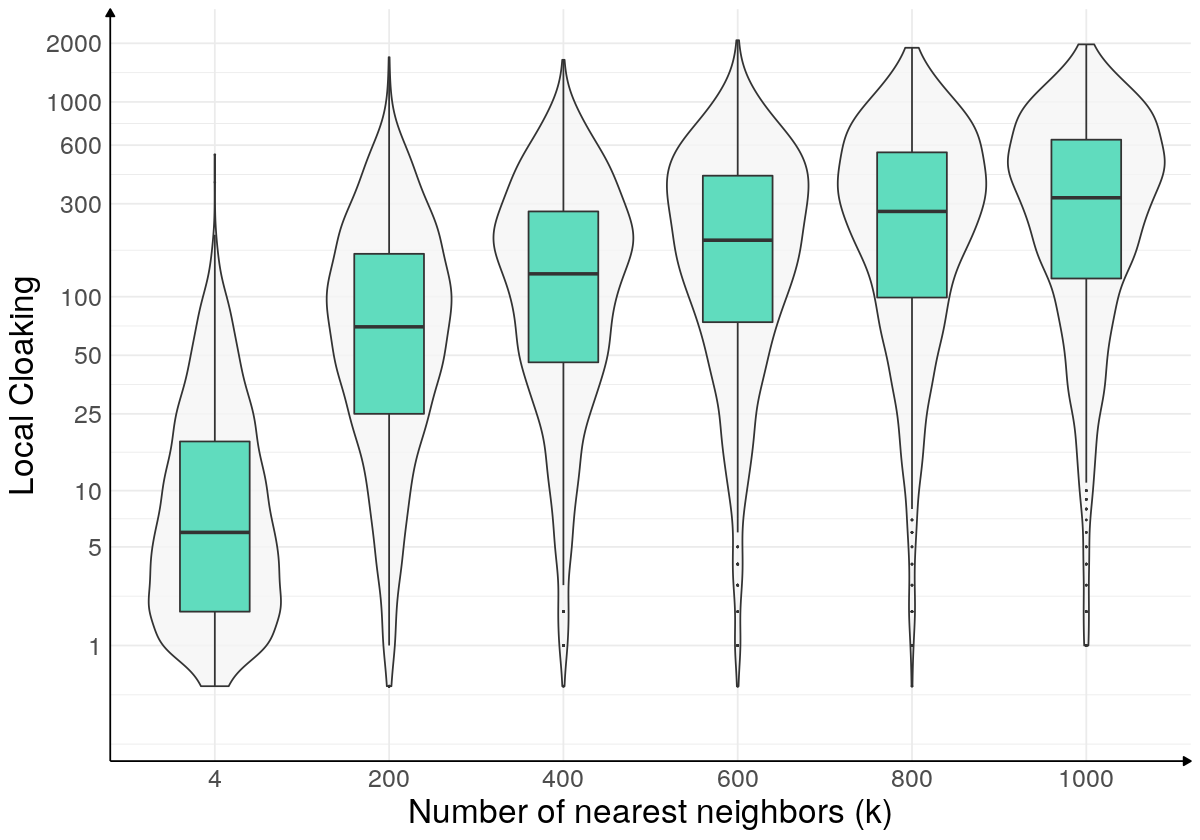

In [39]:
save = FALSE

plot = ggplot(df_melt, aes(x = variable, y =value)) + 
    geom_violin(trim=TRUE, alpha = 0.8, fill = "#F5F5F5")+
    geom_boxplot(width=0.4, fill = colors['avatar', 'color'], outlier.size = 0.1,alpha = 0.8) +
    scale_x_discrete(labels = as.character(seq_k)) +
    scale_y_continuous(trans=scales::pseudo_log_trans(base = 10), breaks = c(1,5,10,25,50,100,300, 600, 1000, 2000)) +
    xlab("Number of nearest neighbors (k)") +
    ylab("Local Cloaking") +
    theme_minimal() +  
    theme(legend.position = "none",
          axis.title.y = element_text(angle = 90, vjust = 1, size = 20),
          axis.text=element_text(size=15), 
          axis.title.x = element_text(size = 20),
          axis.line = element_line(colour = "black", 
                      size = 0.5, linetype = "solid", arrow = arrow(type='closed', length = unit(5,'pt'))))+ 
    coord_cartesian(ylim = c(-1, 2000))

plot

ggsave(file="../../figure/aids_localCloaking_violinplot.svg", plot=plot, width=10, height=7)
